# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<b>План работы</b>
<p>1.Загрузить и изучить данные
<p>2.Заполнить пропущенные значения и обработать аномалии в столбцах. 
<p>3.Подготовить выборки для обучения моделей.
<p>4.Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
<p>5.Проанализировать время обучения, время предсказания и качество моделей.
<p>6.Выберете лучшую модель по критериям заказчика и проверить её качество на тестовой выборке.

## Подготовка данных

### Импорт необходимых библиотек

In [1]:
! pip install phik

In [2]:
! pip install lightgbm

In [3]:
! pip install optuna

In [4]:
! pip install catboost

In [5]:
import pandas as pd
import numpy as np
import phik
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

from sklearn.dummy import DummyRegressor

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.model_selection import GridSearchCV



pd.options.mode.chained_assignment = None

### Загрузка и  первичное изучение данных

In [6]:
df = pd.read_csv('/datasets/autos.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.sample(7)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
269764,2016-04-06 11:25:37,3750,sedan,2005,manual,120,astra,150000,2,gasoline,opel,no,2016-04-06 00:00:00,0,60596,2016-04-06 12:06:16
182702,2016-03-11 17:39:01,3300,sedan,2002,manual,131,golf,150000,3,gasoline,volkswagen,no,2016-03-11 00:00:00,0,22149,2016-04-05 17:17:03
193173,2016-04-01 13:52:08,7900,wagon,2010,manual,105,golf,125000,2,gasoline,volkswagen,yes,2016-04-01 00:00:00,0,90763,2016-04-05 08:51:02
87079,2016-03-08 07:01:08,1450,sedan,1991,manual,90,passat,125000,11,petrol,volkswagen,no,2016-03-08 00:00:00,0,67657,2016-03-09 22:44:57
133494,2016-03-08 17:45:38,1350,sedan,1994,auto,116,passat,150000,12,petrol,volkswagen,yes,2016-03-08 00:00:00,0,31061,2016-04-07 06:46:30
160950,2016-03-13 19:21:46,0,NaN,2005,NaN,0,mondeo,5000,0,gasoline,ford,NaN,2016-03-13 00:00:00,0,57627,2016-03-16 05:47:26
170291,2016-04-02 23:51:48,4200,coupe,2001,manual,147,astra,125000,10,petrol,opel,no,2016-04-02 00:00:00,0,6556,2016-04-07 05:17:44


In [9]:
df_obj = df.select_dtypes(include=['object']).columns
df_obj

Index(['DateCrawled', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'LastSeen'],
      dtype='object')

In [10]:
df_int = df.select_dtypes(include=['int64']).columns
df_int

Index(['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'NumberOfPictures', 'PostalCode'],
      dtype='object')

Данные содержат 354369 строк и 16 столбцов. Имеются признаки в формате 'object': DateCrawled', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired', 'DateCreated', 'LastSeen' и 'int64': 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode'. Необходимо отметить, что DateCrawled — дата скачивания анкеты из базы, DateCreated — дата создания анкеты и LastSeen — дата последней активности пользователя имеют формат даты.

In [11]:
#Создадим цикл для изменения типа данных с int64 на int32 с целью экономии памяти
for col in df.columns:
    if col in df_int:
        df[col] = df[col].astype('int32')

In [12]:
#определим количество пропущенных значений для каждого столбца
pd.DataFrame(df.isna().mean()*100,columns=['Процент пропусков']).style.background_gradient('PRGn')

,Процент пропусков
DateCrawled,0.000000
Price,0.000000
VehicleType,10.579368
RegistrationYear,0.000000
Gearbox,5.596709
Power,0.000000
Model,5.560588
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.282697


Больше всего пропущенных значений в столбце Repaired (более 20%), также имеются пропуски в VehicleType (10.6%), FuelType(9.3%), Gearbox (5.6%), Model (5.6%).

In [13]:
#Приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [14]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В столбце price, видим, что имеется нулевое значение, registration_year - не все значения заполнены корректно (имеется год 1000 и год 9999), power и registration_month (имеется значение 0), number_of_pictures (все значения 0)

Признаки с датами и почтовый индекс владельца анкеты, а также месяц регистрации автомобиля и количество фотографий автомобиля, нам не понадобятся для обучения, оставим только важные для обучения признаки.

In [15]:
data = df[['vehicletype', 'registrationyear', 'gearbox','power', 'model', 'kilometer', 'fueltype', 'brand', 'repaired', 'price' ]]

In [16]:
#Переименуем столбцы в соответствии со змеиным регистром
data = data.rename(columns={'vehicletype':'vehicle_type', 'registrationyear':'registration_year', 'fueltype':'fuel_type' })

In [17]:
data.sample(7)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,price
13377,sedan,2005,NaN,105,astra,125000,petrol,opel,no,3750
66893,sedan,2007,auto,197,5er,150000,gasoline,bmw,no,12000
238678,bus,1999,auto,114,other,80000,petrol,mazda,no,2299
309394,small,2003,manual,58,twingo,90000,petrol,renault,no,1199
178571,sedan,2001,auto,102,golf,50000,petrol,volkswagen,no,4499
111527,bus,2005,manual,102,toledo,125000,petrol,seat,no,4250
295500,bus,2005,manual,110,c_max,150000,gasoline,ford,no,4500


In [18]:
# Матрица phik-корреляции
phik_overview = data.phik_matrix()
phik_overview.round(2).style.background_gradient('PRGn')

interval columns not set, guessing: ['registration_year', 'power', 'kilometer', 'price']


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,price
vehicle_type,1.000000,nan,0.290000,0.010000,0.920000,0.170000,0.330000,0.630000,0.080000,0.270000
registration_year,nan,1.000000,0.000000,0.090000,0.080000,0.230000,0.040000,0.050000,0.010000,0.010000
gearbox,0.290000,0.000000,1.000000,0.010000,0.650000,0.020000,0.150000,0.520000,0.040000,0.320000
power,0.010000,0.090000,0.010000,1.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.010000
model,0.920000,0.080000,0.650000,0.000000,1.000000,0.440000,0.550000,1.000000,0.160000,0.580000
kilometer,0.170000,0.230000,0.020000,0.000000,0.440000,1.000000,0.150000,0.280000,0.110000,0.310000
fuel_type,0.330000,0.040000,0.150000,0.010000,0.550000,0.150000,1.000000,0.320000,0.040000,0.260000
brand,0.630000,0.050000,0.520000,0.000000,1.000000,0.280000,0.320000,1.000000,0.110000,0.360000
repaired,0.080000,0.010000,0.040000,0.010000,0.160000,0.110000,0.040000,0.110000,1.000000,0.380000
price,0.270000,0.010000,0.320000,0.010000,0.580000,0.310000,0.260000,0.360000,0.380000,1.000000


Сильная связь наблюдается между маркой авто и моделью, типом кузова и моделью, также связь имеется между признаками: тип коробки передач и моделью, маркой авто и типом кузова. На цену сильнее всего влияет модель авто.

In [19]:
pd.set_option('display.max_rows', None)
# Рассмотрим уникальные значения
for i in data.columns:
    print()
    print('Уникальные значения для столбца','\033[1m' + i + '\033[0m',':', data[i].sort_values().unique())


Уникальные значения для столбца vehicle_type : ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

Уникальные значения для столбца registration_year : [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]

Уникальные значения для столбца gearbox : ['auto' 'manual' 

Мы определили, что имеются пропущенные значения, часть признаков неинформативна для обучения модели, их убрали, при заполнении данных много ошибок, имеется сильная связь между кузовом автомобиля и моделью

### Заполнение пропусков и устранение аномалий

In [20]:
data.sample(7)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,price
316279,sedan,2007,manual,122,1er,80000,petrol,bmw,no,8600
281075,sedan,1999,manual,131,focus,150000,petrol,ford,NaN,1520
44074,small,2013,manual,75,corsa,150000,gasoline,opel,no,7890
236225,small,2011,manual,75,sandero,100000,petrol,dacia,no,4400
328869,coupe,2003,manual,143,c_klasse,150000,gasoline,mercedes_benz,no,2499
235548,wagon,2008,auto,140,octavia,150000,gasoline,skoda,no,3990
231916,convertible,2004,manual,125,tigra,80000,petrol,opel,no,4499


In [21]:
data['model'].value_counts(dropna = False).head(7)

golf     29232
other    24421
3er      19761
NaN      19705
polo     13066
corsa    12570
astra    10809
Name: model, dtype: int64

Больше всего моделей автомобилей:golf, на втором месте - "other", пропущенные значения на 4 месте по количеству. Так как модель автомобиля является довольно значимым фактором, при определении цены и пропущенные значения по признаку 'model' составляют менее 6%, удалим их, чтобы не исказить модель.

In [22]:
data = data.dropna(subset=['model'])

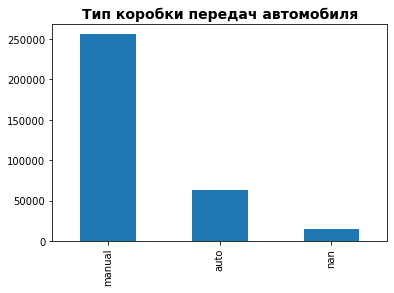

In [23]:
data['gearbox'].value_counts(dropna = False).plot(kind = 'bar')
plt.title('Тип коробки передач автомобиля',fontdict= {'fontsize': 14, 'fontweight':'bold'});

Количество пропущенных значений по признаку 'gearbox' составляет менее 6%, удалим  и их

In [24]:
data = data.dropna(subset=['gearbox'])

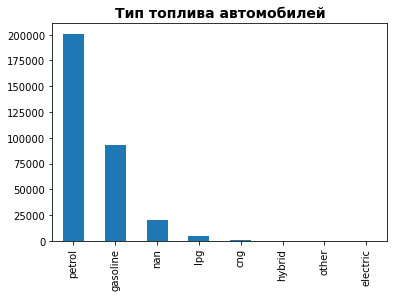

In [25]:
data['fuel_type'].value_counts(dropna = False).plot(kind = 'bar')
plt.title('Тип топлива автомобилей',fontdict= {'fontsize': 14, 'fontweight':'bold'});

Уникальные типы топлива ('cng' 'electric' 'gasoline' 'hybrid' 'lpg' 'other' 'petrol' nan): CNG (Compressed Natural Gas) – сжатый природный газ (метан), электротопливо, LPG (Liquified Petroleum Gas) – сжиженный нефтяной газ (пропан-бутан), а вот 'gasoline' и 'petrol' - одно и тоже (бензин). Устраним данный дубликат и пропущенные значения заменим на 'other'.

In [26]:
data['fuel_type'] = data['fuel_type'].replace('gasoline', 'petrol').fillna('other')

Рассмотрим признак registration_year.

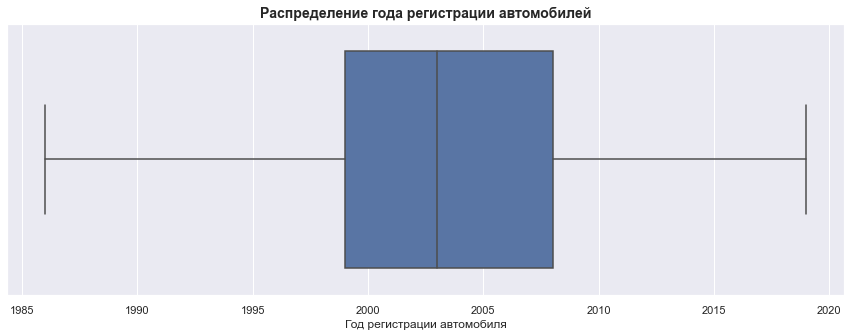

In [27]:
#Построим график с усами без выбросов, для более детального рассмотрения 

sns.set(rc={'figure.figsize':(15,5)})
pt = sns.boxplot(data=data, x='registration_year', showfliers=False)
pt.set_title('Распределение года регистрации автомобилей',fontdict= {'fontsize': 14, 'fontweight':'bold'})
pt.set(xlabel='Год регистрации автомобиля');

In [28]:
statistic = data['registration_year'].describe()
# межквартильный размах
interquartile_range = statistic[6] - statistic[4]
    
# левая и правая граница    
left_border = statistic[4] - 1.5 * interquartile_range
right_border = statistic[6] + 1.5 * interquartile_range

print(left_border, right_border)

1985.5 2021.5


Мы определили, что верхняя граница - 2021 год, однако у нас есть дата скачивания анкеты, позднее которой эта дата быть не может. Следовательно, верхняя граница будет - год скачивания анкеты.

In [29]:
# Определим самое позднее время скачивания анкеты
df['datecrawled'] = pd.to_datetime(df['datecrawled'])
df['datecrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [30]:
data = data.query('registration_year>=1985 & registration_year<=2016')

Рассмотрим признак power

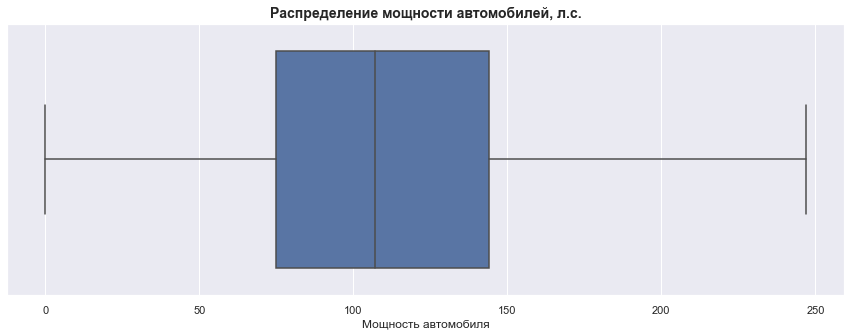

In [31]:
#Построим график с усами без выбросов, для более детального рассмотрения 

sns.set(rc={'figure.figsize':(15,5)})
pt = sns.boxplot(data=data, x='power', showfliers=False)
pt.set_title('Распределение мощности автомобилей, л.с.',fontdict= {'fontsize': 14, 'fontweight':'bold'})
pt.set(xlabel='Мощность автомобиля');

In [32]:
data['power'].value_counts(dropna = False).head(7)

75     21139
0      21115
60     13956
150    13344
101    12052
140    11979
90     11249
Name: power, dtype: int64

Довольно много нулевых значений. Выбросов, среди больших значений, гораздо меньше. Это явная ошибка, при заполнении данных, нулевые значения не добавят точности нашей модели, так же, как и слишком большие значения. Отбросим по 1% данных с большей стороны. Нижнюю границу определим как 30 л.с.

In [33]:
print('Правая граница мощности:',data['power'].quantile(.99))

Правая граница мощности: 300.0


In [34]:
data = data.query('power>=30 & power<=300')

Рассмотрим признак 'repaired'

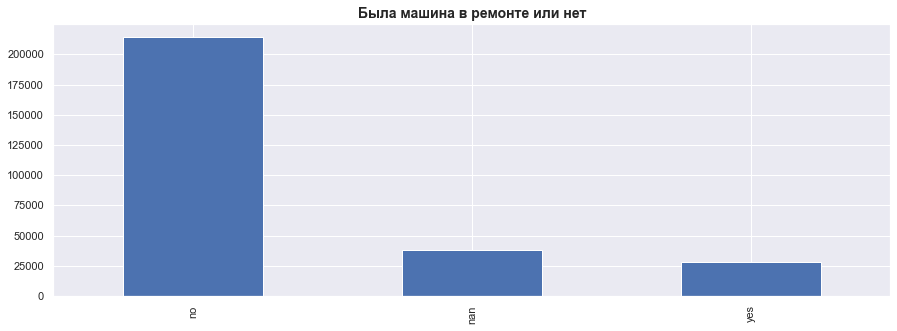

In [35]:
data['repaired'].value_counts(dropna = False).plot(kind = 'bar')
plt.title('Была машина в ремонте или нет',fontdict= {'fontsize': 14, 'fontweight':'bold'});

Автомобилей с указанием того, что она была в ремонте подозрительно мало. При этом, пропущенных значений в первоначальном датасете более 20%, следовательно, удалять их не будем, заменим на значение 'unknown'.

In [36]:
data['repaired'] = data['repaired'].fillna('unknown')

Рассмотрим целевой признак "price"

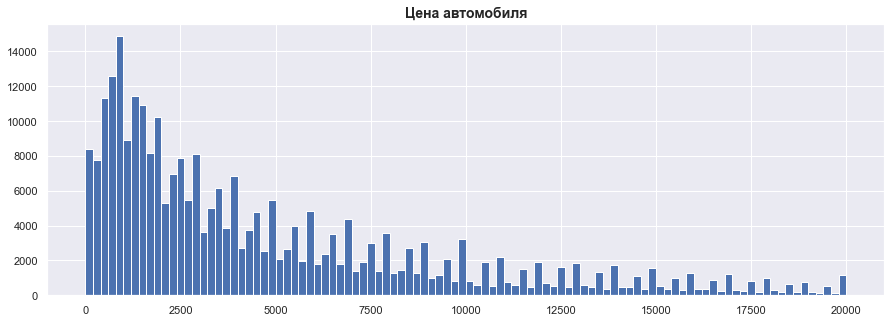

In [37]:
data['price'].hist(bins=100)
plt.title('Цена автомобиля',fontdict= {'fontsize': 14, 'fontweight':'bold'});

Среди значений есть значения 0,1,2..что очень нереалистично. Определим минимальное значение в районе 100 евро.

In [38]:
data = data.query('price>=100')

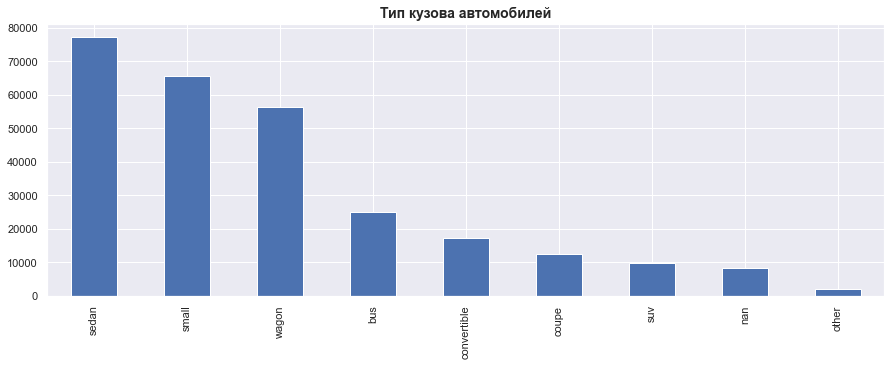

In [39]:
data['vehicle_type'].value_counts(dropna = False).plot(kind = 'bar')
plt.title('Тип кузова автомобилей',fontdict= {'fontsize': 14, 'fontweight':'bold'});

Больше всего автомобилей с типом кузова sedan, small и wagon. На 4 месте - пропущенные значения. Заменим их на значение "unknown". 

In [40]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273868 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicle_type       273868 non-null  object
 1   registration_year  273868 non-null  int32 
 2   gearbox            273868 non-null  object
 3   power              273868 non-null  int32 
 4   model              273868 non-null  object
 5   kilometer          273868 non-null  int32 
 6   fuel_type          273868 non-null  object
 7   brand              273868 non-null  object
 8   repaired           273868 non-null  object
 9   price              273868 non-null  int32 
dtypes: int32(4), object(6)
memory usage: 18.8+ MB


Пропущенных значений нет

In [42]:
# Определим количество строк-дубликатов
data.duplicated().sum()

38687

In [43]:
#Удалим строки-дубликаты
data = data.drop_duplicates()

In [44]:
1-len(data)/len(df)

0.3363386752227199

Таким образом, в ходе предобработки данных, было потеряно 33,63% данных. Это довольно много, однако, данных осталось достаточно для обучения. Также, заказчику будет рекомендовано, при разработке приложения учесть моменты: при заполнении пользователями характеристик автомобилей, невозможность пропускать характеристики и параметры моделей будут в определенном диапазоне. Следуя этой мысли, в разработку пайплайна, импутер мы включать не стали.

## Обучение моделей

### Определим выборки для обучения моделей.

Определим признаки для обучения и целевой признак

In [45]:
features = data.drop('price', axis = 1)
target = data['price']

Разобъем датасет на тренировочную (полную) и тестовую выборки в соотношении 80-20

In [46]:
features_train_full, features_test, target_train_full, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

Полную тренировочную выборку разбили на тренировочную и валидационную (для моделей без кроссвалидации)

In [47]:
features_train, features_valid, target_train, target_valid = train_test_split(features_train_full, target_train_full, test_size=0.25, random_state=42)

In [48]:
len(target_test)/len(target)

0.2000034016353362

In [49]:
len(target_valid)/len(target)

0.19999914959116596

Данные разбиты корректно

### Создание pipeline для подготовки данных

Определим категориальные и числовые признаки

In [50]:
cat_cols = features_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = features_train.select_dtypes(exclude=["object"]).columns.tolist()

Для деревянных моделей будем использовать OrdinalEncoder, а OneHotEncoder для Ближайших соседей

In [51]:
# pipeline для категориальных значений для деревянных моделей
cat_preprocessing = make_pipeline(
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
)

# pipeline для категориальных значений для линейных моделей
cat_preprocessing_lin = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)

# pipeline для числовых значений
num_preprocessing = make_pipeline(StandardScaler())

# Объединяем оба pipeline используя columnTransformer для деревянных моделей
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing, cat_cols)]
)

# Объединяем оба pipeline используя columnTransformer для линейных моделей
preprocessing_lin = ColumnTransformer(
    [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing_lin, cat_cols)]
)


### Модели без настройки гиперпараметров

Создадим функцию для графического изображения предсказанных ответов относительно реальных значений

In [52]:
def plot (model, pred):
    plot = pd.DataFrame({'original':target_valid, 'predicted':pred})
    plot = plot.sample(150).sort_index()
# Визуализация предсказанных значений
    x_ax = range(len(plot))
    plt.figure(figsize=(17, 6))
    plt.plot(x_ax, plot['original'], label="original")
    plt.plot(x_ax, plot['predicted'], label="predicted")
    plt.title(f"Предсказание модели {model}")
    plt.ylabel('Price')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

#### RandomForestRegressor

In [53]:
# Полный pipeline для RandomForestRegressor
full_pipe_rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)

In [54]:
%%time
start_rf = time.time()
full_pipe_rf.fit(features_train, target_train)
end_rf = time.time()
time_rf_base = end_rf-start_rf

CPU times: total: 53.4 s
Wall time: 53.5 s


In [55]:
%%time
start_rf_pred = time.time()
pred_rf = full_pipe_rf.predict(features_valid)
end_rf_pred = time.time()
time_rf_base_pred = end_rf_pred-start_rf_pred

CPU times: total: 2.58 s
Wall time: 2.59 s


In [56]:
mse_rf = mean_squared_error(target_valid, pred_rf)
rmse_rf = np.sqrt(mse_rf)
print('RMSE случайного леса', rmse_rf)

RMSE случайного леса 1602.1786515732483


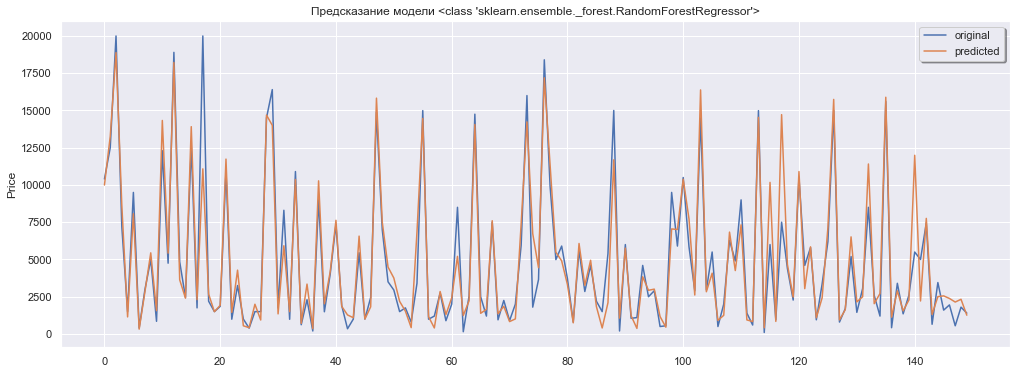

In [57]:
plot(RandomForestRegressor,pred_rf)

#### KNeighborsRegressor

In [58]:
# Полный pipeline для KNeighborsRegressor
full_pipe_kn = Pipeline(
    [
        ("preprocess", preprocessing_lin),
        ("regressor", KNeighborsRegressor()),
    ]
)

In [59]:
%%time
start_kn = time.time()
full_pipe_kn.fit(features_train, target_train)
end_kn = time.time()
time_kn_base = end_kn-start_kn

CPU times: total: 3.33 s
Wall time: 3.33 s


In [60]:
%%time
start_kn_pred = time.time()
pred_kn = full_pipe_kn.predict(features_valid)
end_kn_pred = time.time()
time_kn_base_pred = end_kn_pred-start_kn_pred

CPU times: total: 10min 52s
Wall time: 1min 35s


In [61]:
mse_kn = mean_squared_error(target_valid, pred_kn)
rmse_kn = np.sqrt(mse_kn)
print('RMSE KNeighborsRegressor', rmse_kn)

RMSE KNeighborsRegressor 1721.7790589851709


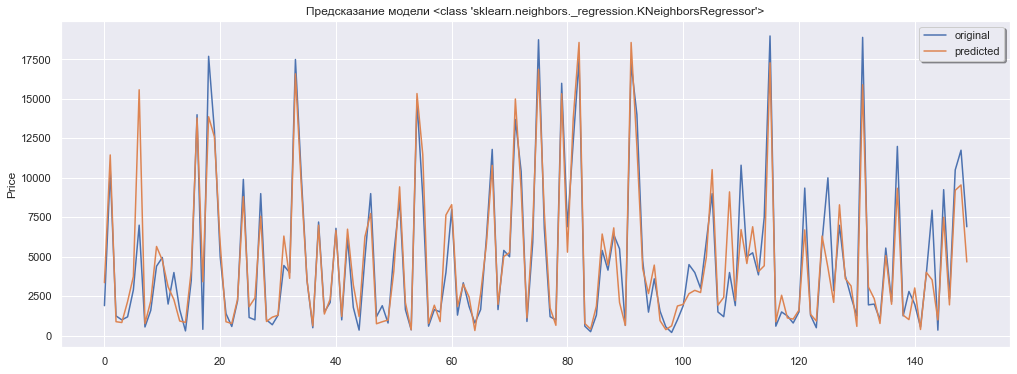

In [62]:
plot(KNeighborsRegressor, pred_kn)

#### LightGBM с OrdinalEncoder

In [63]:
# Полный pipeline для LGBMRegressor
full_pipe_lgb = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", lgb.LGBMRegressor(random_state=42)),
    ]
)

In [64]:
%%time
start_lgb = time.time()
full_pipe_lgb.fit(features_train, target_train)
end_lgb = time.time()
time_lgb_base = end_lgb-start_lgb

CPU times: total: 4.59 s
Wall time: 1.05 s


In [65]:
%%time
start_lgb_pred = time.time()
pred_lgb = full_pipe_lgb.predict(features_valid)
end_lgb_pred = time.time()
time_lgb_base_pred = end_lgb-start_lgb

CPU times: total: 719 ms
Wall time: 208 ms


In [66]:
mse_lgb = mean_squared_error(target_valid, pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
print('RMSE LGBMRegressor с OE', rmse_lgb)

RMSE LGBMRegressor с OE 1606.2348161568696


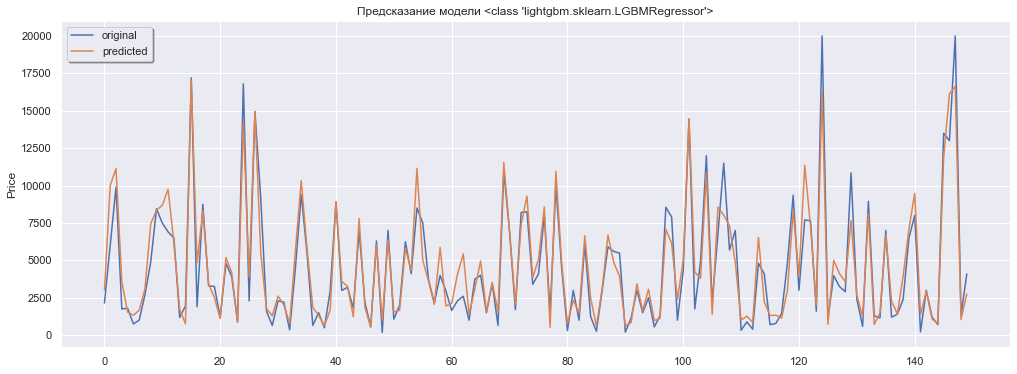

In [67]:
plot(lgb.LGBMRegressor, pred_lgb)

#### LightGBM

In [68]:
features_train_cat = features_train.copy()
features_valid_cat = features_valid.copy()
features_train_full_cat = features_train_full.copy()
features_test_cat = features_test.copy()

In [69]:
for col in cat_cols:
    features_train_cat[col] = features_train_cat[col].astype('category')
    features_valid_cat[col] = features_valid_cat[col].astype('category')
    features_train_full_cat[col] = features_train_full_cat[col].astype('category')
    features_test_cat[col] = features_test_cat[col].astype('category')

In [70]:
features_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141108 entries, 147210 to 198608
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       141108 non-null  category
 1   registration_year  141108 non-null  int32   
 2   gearbox            141108 non-null  category
 3   power              141108 non-null  int32   
 4   model              141108 non-null  category
 5   kilometer          141108 non-null  int32   
 6   fuel_type          141108 non-null  category
 7   brand              141108 non-null  category
 8   repaired           141108 non-null  category
dtypes: category(6), int32(3)
memory usage: 3.6 MB


In [71]:
features_valid_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47036 entries, 13856 to 36631
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   vehicle_type       47036 non-null  category
 1   registration_year  47036 non-null  int32   
 2   gearbox            47036 non-null  category
 3   power              47036 non-null  int32   
 4   model              47036 non-null  category
 5   kilometer          47036 non-null  int32   
 6   fuel_type          47036 non-null  category
 7   brand              47036 non-null  category
 8   repaired           47036 non-null  category
dtypes: category(6), int32(3)
memory usage: 1.2 MB


In [72]:
features_train_full_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188144 entries, 176157 to 171900
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       188144 non-null  category
 1   registration_year  188144 non-null  int32   
 2   gearbox            188144 non-null  category
 3   power              188144 non-null  int32   
 4   model              188144 non-null  category
 5   kilometer          188144 non-null  int32   
 6   fuel_type          188144 non-null  category
 7   brand              188144 non-null  category
 8   repaired           188144 non-null  category
dtypes: category(6), int32(3)
memory usage: 4.9 MB


In [73]:
lgb_molel = lgb.LGBMRegressor(random_state=42)

In [74]:
%%time
start_lgb_1 = time.time()
lgb_molel.fit(features_train_cat, target_train)
end_lgb_1 = time.time()
time_lgb_1 = end_lgb_1-start_lgb_1

CPU times: total: 4.97 s
Wall time: 998 ms


In [75]:
%%time
start_lgb_1_pred = time.time()
lgb_1_pred = lgb_molel.predict(features_valid_cat)
end_lgb_1_pred = time.time()
time_lgb_1_pred = end_lgb_1_pred-start_lgb_1_pred

CPU times: total: 859 ms
Wall time: 163 ms


In [76]:
mse_lgb_1 = mean_squared_error(target_valid, lgb_1_pred)
rmse_lgb_1 = np.sqrt(mse_lgb_1)
print('RMSE LightGBM', rmse_lgb_1)

RMSE LightGBM 1532.10440014461


#### Catboost с OrdinalEncoder

In [77]:
# Полный pipeline для Catboost
full_pipe_cat = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", CatBoostRegressor(random_state=42, verbose=20)),
    ]
)

In [78]:
%%time
start_cat = time.time()
full_pipe_cat.fit(features_train, target_train)
end_cat = time.time()
time_cat_base = end_cat-start_cat

Learning rate set to 0.089497
0:	learn: 4352.1193271	total: 161ms	remaining: 2m 40s
20:	learn: 2210.4473797	total: 610ms	remaining: 28.4s
40:	learn: 1911.6697804	total: 1.02s	remaining: 23.8s
60:	learn: 1808.0965242	total: 1.39s	remaining: 21.5s
80:	learn: 1752.1950599	total: 1.78s	remaining: 20.2s
100:	learn: 1715.1415713	total: 2.18s	remaining: 19.4s
120:	learn: 1688.3210386	total: 2.59s	remaining: 18.8s
140:	learn: 1667.3657305	total: 3s	remaining: 18.3s
160:	learn: 1649.9911564	total: 3.39s	remaining: 17.7s
180:	learn: 1636.6655033	total: 3.79s	remaining: 17.2s
200:	learn: 1625.4228527	total: 4.18s	remaining: 16.6s
220:	learn: 1614.9014402	total: 4.57s	remaining: 16.1s
240:	learn: 1605.5041557	total: 4.98s	remaining: 15.7s
260:	learn: 1596.2077855	total: 5.4s	remaining: 15.3s
280:	learn: 1588.2799883	total: 5.78s	remaining: 14.8s
300:	learn: 1581.0283663	total: 6.2s	remaining: 14.4s
320:	learn: 1573.8111516	total: 6.63s	remaining: 14s
340:	learn: 1566.5393599	total: 7.04s	remaining

In [79]:
%%time
start_cat_pred = time.time()
pred_cat = full_pipe_cat.predict(features_valid)
end_cat_pred = time.time()
time_cat_base_pred = end_cat_pred-start_cat_pred

CPU times: total: 219 ms
Wall time: 236 ms


In [80]:
mse_cat = mean_squared_error(target_valid, pred_cat)
rmse_cat = np.sqrt(mse_cat)
print('RMSE Catboost OE', rmse_cat)

RMSE Catboost OE 1528.338081998898


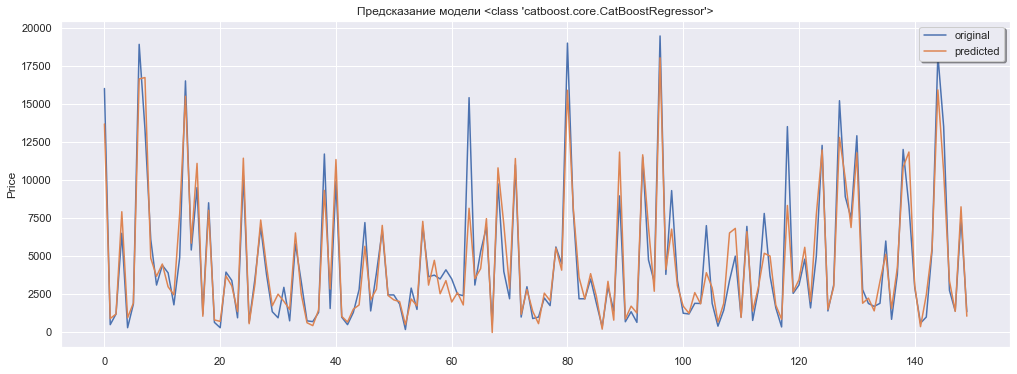

In [81]:
plot(CatBoostRegressor, pred_cat)

#### Catboost

In [82]:
cat = CatBoostRegressor(random_state=42, verbose=30)

In [83]:
pool_train = Pool(features_train, target_train,
                  cat_features = cat_cols)

pool_test = Pool(features_valid, cat_features = cat_cols)

In [84]:
%%time
start_cat_cat = time.time()
cat.fit(pool_train)
end_cat_cat = time.time()
time_cat_base_cat = end_cat-start_cat

Learning rate set to 0.089497
0:	learn: 4350.9907149	total: 144ms	remaining: 2m 24s
30:	learn: 1889.6838282	total: 4.13s	remaining: 2m 8s
60:	learn: 1730.7899530	total: 7.84s	remaining: 2m
90:	learn: 1678.1743188	total: 11.4s	remaining: 1m 53s
120:	learn: 1642.9214983	total: 14.9s	remaining: 1m 48s
150:	learn: 1616.7875719	total: 18.6s	remaining: 1m 44s
180:	learn: 1598.8876926	total: 22.3s	remaining: 1m 40s
210:	learn: 1584.5494214	total: 25.9s	remaining: 1m 36s
240:	learn: 1572.4848110	total: 29.3s	remaining: 1m 32s
270:	learn: 1564.8806343	total: 32.8s	remaining: 1m 28s
300:	learn: 1556.6933243	total: 36.2s	remaining: 1m 24s
330:	learn: 1548.3686829	total: 40s	remaining: 1m 20s
360:	learn: 1541.9699259	total: 43.5s	remaining: 1m 17s
390:	learn: 1535.7076853	total: 47.1s	remaining: 1m 13s
420:	learn: 1529.3323640	total: 50.7s	remaining: 1m 9s
450:	learn: 1523.5667205	total: 54.3s	remaining: 1m 6s
480:	learn: 1518.5822819	total: 57.9s	remaining: 1m 2s
510:	learn: 1512.4277407	total: 1

In [85]:
%%time
start_cat_pred_cat = time.time()
cat_cat_pred = cat.predict(pool_test)
end_cat_pred_cat = time.time()
time_cat_base_cat_pred = end_cat_pred_cat-start_cat_pred_cat

CPU times: total: 938 ms
Wall time: 153 ms


In [86]:
mse_cat_cat = mean_squared_error(target_valid, cat_cat_pred)
rmse_cat_cat = np.sqrt(mse_cat_cat)
print('RMSE Catboost', rmse_cat_cat)

RMSE Catboost 1528.5360032039962


#### DummyRegressor для проверки на адекватность

In [87]:
# Полный pipeline для DummyRegressor
full_pipe_dummy = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", DummyRegressor()),
    ]
)

In [88]:
%%time
start_dummy = time.time()
full_pipe_dummy.fit(features_train, target_train)
end_dummy = time.time()
time_dummy_base = end_dummy-start_dummy

CPU times: total: 359 ms
Wall time: 338 ms


In [89]:
%%time
start_dummy_pred = time.time()
pred_dummy = full_pipe_dummy.predict(features_valid)
end_dummy_pred = time.time()
time_dummy_base_pred = end_dummy_pred-start_dummy_pred

CPU times: total: 141 ms
Wall time: 156 ms


In [90]:
mse_dummy = mean_squared_error(target_valid, pred_dummy)
rmse_dummy = np.sqrt(mse_dummy)
print('RMSE DummyRegressor', rmse_dummy)

RMSE DummyRegressor 4596.390861197918


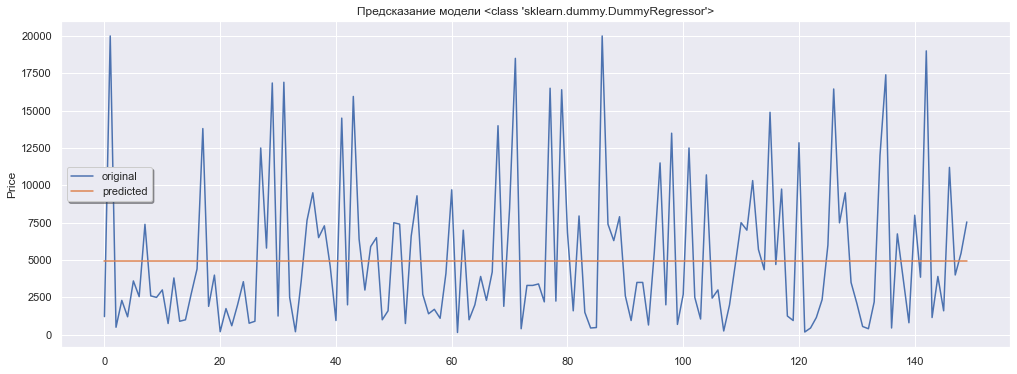

In [91]:
plot(DummyRegressor, pred_dummy)

In [92]:
base_model = pd.DataFrame({
    'Модель': ['RandomForestRegressor', 'KNeighborsRegressor','LGBMRegressorOE','LGBMRegressor', 'CatBoostRegressorOE','CatBoostRegressor', 'DummyRegressor'],
    'Время обучения, сек':[time_rf_base, time_kn_base, time_lgb_base, time_lgb_1, time_cat_base,time_cat_base_cat, time_dummy_base],
    'Время предсказания модели,сек':[time_rf_base_pred, time_kn_base_pred, time_lgb_base_pred,time_lgb_1_pred, time_cat_base_pred,time_cat_base_cat_pred, time_dummy_base_pred],
    'Общее время,сек':[time_rf_base+time_rf_base_pred, time_kn_base+time_kn_base_pred, time_lgb_base+time_lgb_base_pred,time_lgb_1+time_lgb_1_pred, time_cat_base+time_cat_base_pred,time_cat_base_cat+time_cat_base_cat_pred, time_dummy_base+time_dummy_base_pred],
    'RMSE': [rmse_rf, rmse_kn, rmse_lgb,rmse_lgb_1, rmse_cat,rmse_cat_cat, rmse_dummy]
})
base_model

,Модель,"Время обучения, сек","Время предсказания модели,сек","Общее время,сек",RMSE
0,RandomForestRegressor,53.474168,2.587083,56.061251,1602.178652
1,KNeighborsRegressor,3.334156,95.837174,99.171330,1721.779059
2,LGBMRegressorOE,1.045694,1.045694,2.091388,1606.234816
3,LGBMRegressor,0.998074,0.163009,1.161083,1532.104400
4,CatBoostRegressorOE,27.536559,0.236013,27.772572,1528.338082
5,CatBoostRegressor,27.536559,0.153008,27.689566,1528.536003
6,DummyRegressor,0.338023,0.155999,0.494022,4596.390861


Все модели показали результат гораздо лучше Дамми модели. Наилучший показатель RMSE у модели CatBoostRegressor с OE , также хорошо показали себя модели RandomForestRegressor и LGBMRegressor. При этом, наименьшее время обучения и предсказания у модели LGBMRegressor (если не считать Дамми модель).

Мы использовали базовые модели без настройки гиперпараметров, попробуем улучшить, полученные результаты

### Модели с настройками гиперпараметров

Для обучения будем использовать optuna и полный трейн, чтобы было больше данных для обучения. Подбирать параметры будем для моделей, которые получили лучший результат по базовой модели: LightGBM и Catboost с OE ( они получили приблизительно одинаковый результат). RandomForestRegressor значительно проигрывает по времени обучения. KNeighborsRegressor хуже по RMSE. 

#### LightGBM

In [93]:
%%time
param_grid_lgb = {
              'boosting_type':optuna.distributions.CategoricalDistribution(['gbdt', 'dart']),
              'learning_rate': optuna.distributions.FloatDistribution(0.1, 0.3, step = 0.05),
              'n_estimators': optuna.distributions.IntDistribution(400,700,step = 50),
             }
search_cv_lgb = OptunaSearchCV(estimator=lgb_molel,
                           param_distributions=param_grid_lgb,
                           scoring='neg_root_mean_squared_error',
                           verbose=20,
                           n_jobs=-1,
                           n_trials=20,
                           cv=3,
                           random_state=42
                          )
search_cv_lgb.fit(features_train_full_cat, target_train_full)
print('RMSE', (-search_cv_lgb.best_score_))
print(pd.Series(search_cv_lgb.best_params_))

<timed exec>:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-04-07 06:35:37,813] A new study created in memory with name: no-name-a24d4003-ce03-486f-b4fc-0260ec793064
[I 2023-04-07 06:35:37,817] Searching the best hyperparameters using 188144 samples...
[I 2023-04-07 06:37:14,133] Trial 7 finished with value: -1497.6501195664723 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2, 'n_estimators': 450}. Best is trial 7 with value: -1497.6501195664723.
[I 2023-04-07 06:37:17,063] Trial 2 finished with value: -1507.9361844333434 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'n_estimators': 500}. Best is trial 7 with value: -1497.6501195664723.
[I 2023-04-07 06:37:51,457] Trial 0 finished with value: -1508.3006748807718 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.3, 'n_estimators': 550}. Best is trial 7 with value: -1497.6501195664723.
[I 2023-04-07 06:38:22,541] T

RMSE 1481.3283174824298
boosting_type    dart
learning_rate    0.25
n_estimators      700
dtype: object
CPU times: total: 3h 22min 29s
Wall time: 30min 20s


Определим время обучения и предсказания для LightGBM с настроенными параметрами для полной выборки

In [94]:
model_lgbm_best = search_cv_lgb.best_estimator_

In [95]:
%%time
start_lgbm_best = time.time()
lgbm_best = model_lgbm_best.fit(features_train_full_cat, target_train_full)
end_lgbm_best = time.time()
time_lgbm_best = end_lgbm_best-start_lgbm_best
print('Время обучения на полной выборке', time_lgbm_best)

Время обучения на полной выборке 147.74879360198975
CPU times: total: 12min 36s
Wall time: 2min 27s


In [96]:
%%time
start_lgbm_best_pred = time.time()
lgbm_best_pred = model_lgbm_best.predict(features_train_full_cat)
end_lgbm_best_pred = time.time()
time_lgbm_best_pred = end_lgbm_best_pred-start_lgbm_best_pred
print('Время предсказания на полной выборке', time_lgbm_best_pred)

Время предсказания на полной выборке 2.7843868732452393
CPU times: total: 19.7 s
Wall time: 2.78 s


In [97]:
mse_lgbm_best = mean_squared_error(target_train_full, lgbm_best_pred)
rmse_lgbm_best = np.sqrt(mse_lgbm_best)
print('RMSE LightGBM', rmse_lgbm_best)

RMSE LightGBM 1357.3932002189515


После подбора гиперпараметров, метрика качества на полной выборке составила 1482

#### Catboost с OE

In [98]:
# Полный pipeline для Catboost
full_pipe_cat = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", CatBoostRegressor(random_state=42, logging_level = "Silent")),
    ]
)

In [99]:
%%time

# Настройка параметров с GridSearch для Catboost

param_grid_cat = {
    
    "regressor__learning_rate": [0.05, 0.1, 0.2],
    "regressor__depth": [4,8,10]
    
}
grid_cat = GridSearchCV(full_pipe_cat, param_grid=param_grid_cat, scoring='neg_root_mean_squared_error', cv=3)
grid_cat.fit(features_train_full, target_train_full)

print('RMSE', '%.4f' %(- grid_cat.best_score_))
print(pd.Series(grid_cat.best_params_))

RMSE 1500.1304
regressor__depth            10.0
regressor__learning_rate     0.1
dtype: float64
CPU times: total: 1h 3min 21s
Wall time: 12min 25s


In [100]:
model_cat_best = grid_cat.best_estimator_

Определим время обучения и предсказания для Catboost с настроенными параметрами для полной выборки

In [101]:
%%time
start_cat_best = time.time()
cat_best = model_cat_best.fit(features_train_full, target_train_full)
end_cat_best = time.time()
time_cat_best = end_cat_best-start_cat_best
print('Время обучения на полной выборке', time_cat_best)


Время обучения на полной выборке 52.107330560684204
CPU times: total: 4min 13s
Wall time: 52.1 s


In [102]:
%%time
start_cat_best_pred = time.time()
cat_best_pred = model_cat_best.predict(features_train_full)
end_cat_best_pred = time.time()
time_cat_best_pred = end_cat_best_pred-start_cat_best_pred
print('Время предсказания на полной выборке', time_cat_best_pred)

Время предсказания на полной выборке 1.691056251525879
CPU times: total: 5.22 s
Wall time: 1.69 s


In [103]:
mse_cat_best = mean_squared_error(target_train_full, cat_best_pred)
rmse_cat_best = np.sqrt(mse_cat_best)
print('RMSE Catboost', rmse_cat_best)

RMSE Catboost 1301.0191704117885


In [104]:
best_model = pd.DataFrame({
    'Модель': ['LGBMRegressor', 'CatBoostRegressorOE'],
    'Время обучения, сек':[ time_lgbm_best, time_cat_best],
    'Время предсказания модели,сек':[ time_lgbm_best_pred, time_cat_best_pred],
    'Общее время,сек':[time_lgbm_best+time_lgbm_best_pred, time_cat_best+time_cat_best_pred],
    'RMSE': [rmse_lgbm_best, rmse_cat_best]
})
best_model

,Модель,"Время обучения, сек","Время предсказания модели,сек","Общее время,сек",RMSE
0,LGBMRegressor,147.748794,2.784387,150.533180,1357.39320
1,CatBoostRegressorOE,52.107331,1.691056,53.798387,1301.01917


После подборов гиперпараметров, результат для LGBMRegressor хуже как по времени, так и по качеству, чем Catboost выберем вторую модель для тестирования

In [105]:
%%time
cat_test_pred = model_cat_best.predict(features_test)
mse_cat_test = mean_squared_error(target_test, cat_test_pred)
rmse_cat_test = np.sqrt(mse_cat_test)
print('RMSE Catboost', rmse_cat_test)


RMSE Catboost 1487.449128733029
CPU times: total: 1.39 s
Wall time: 428 ms


На тестовой модели, получили неплохой результат  = 1487

## Вывод

В ходе предобработки данных была проведена большая работа по устранению аномалий и пропущенных значений. Довольно значительная часть была удалена. Это было сделано с учетом рекомендаций заказчику по поводу необходимости разработки приложения, не допускающего пропуски, при заполнении характеристик автомобилей и указания значений в определенном диапазоне. Базовые модели LightGBM и Catboost показали себя хорошо. Catboost проверяли с OE и без (модель самостоятельно обрабатывает категориальные признаки), особой разницы нет. После подборов гиперпараметров, результат для LGBMRegressor хуже как по времени, так и по качеству, чем Catboost выберем вторую модель для тестирования. На тестовой модели получили RMSE = 1487